In [1]:
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import rubrix as rb
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [ ]:
import nltk
nltk.download('stopwords')

In [17]:
data_scraped = pd.read_csv("D:\Downloads\Twitter_Data_Emotion_Scraped_v2.csv")

C:\Users\pradi\AppData\Local\Temp\ipykernel_27788\422823997.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data_scraped = pd.read_csv("D:\Downloads\Twitter_Data_Emotion_Scraped_v2.csv")


In [20]:
data_scraped = data_scraped.drop(columns=['id', 'conversation_id','created_at','date','time','timezone','user_id','username','name','place','language','mentions','urls','photos','replies_count','retweets_count','likes_count','hashtags','cashtags','link','retweet','quote_url','video','thumbnail','near','geo','source','user_rt_id','user_rt','retweet_id','reply_to','retweet_date','translate','trans_src','trans_dest'])

In [21]:
data_scraped.head(60000)

,tweet
0,@kpertiwi29 Sekarang udah ada union tapiiiiiii...
1,2 people followed me and one person unfollowed...
2,@airaniiofifteen Sore yopp 🥰
3,@pichuu000 Laper yaa mas? Wkwwk
4,@ohyeaharki Oooh can wait
...,...
59995,@tanyakanrl yang di tl itu bukan sih? kalo iya...
59996,Besok ane ttd kontrak ngajar di salah satu SMA...
59997,CHAT WA KEAPUS LGI FAG LAH ANJING CAPEK GUEE
59998,"@PalPriadi @i_m_mortal_ Kak pal, itu yg kiri h..."


In [22]:
import re

#remove unnneccesary characters
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
              

In [23]:
data_scraped['tweet'] = data_scraped['tweet'].apply(remove_tweet_special)

In [12]:
data_scraped['tweet'] = data_scraped['tweet'].str.lower()

In [24]:
data_scraped['tweet'].head(100000)

0            Sekarang udah ada union tapiiiiiiiii.........
1        2 people followed me and one person unfollowed...
2                                              Sore yopp ?
3                                     Laper yaa mas? Wkwwk
4                                            Oooh can wait
                               ...                        
81128    Emang udah paling bener gausah cerita apa? sm ...
81129                                     Merosotin cuy ??
81130            Lahh ternyata ada 1 fans nya yang komen ?
81131    2023-04-10 21:18:49 Employee commercial would ...
81132                   Gatau ko aku taunya Kontol Kejepit
Name: tweet, Length: 81133, dtype: object

In [57]:
import string
import re

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

In [26]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [27]:
raw_sample = data_scraped['tweet'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Ujan woy kemane aje lu?
Case folding	:  ujan woy kemane aje lu


In [28]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')
key_norm

,_id,singkat,hasil
0,1,abis,habis
1,2,accent,tekanan
2,3,accept,terima
3,4,accident,kecelakaan
4,5,achievement,prestasi
...,...,...,...
3715,3716,ywdah,ya sudah
3716,3717,ywdh,ya sudah
3717,3718,ywdhlh,ya sudahlah
3718,3719,ywis,ya sudah


In [29]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [58]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [31]:
def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [32]:
raw_sample = data_scraped['tweet'].iloc[50]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Siap
Case folding		:  siap
Stopword removal	:  


In [33]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [34]:
raw_sample = data_scraped['tweet'].iloc[121]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Hi burung biru
Case folding		:  hi burung biru
Stopword removal	:  hi burung biru
Stemming		:  hi burung biru


In [35]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [31]:
data_scraped2 = data_scraped.sample(n=5000)

In [32]:
data_scraped2.shape

(5000, 1)

In [36]:
%%time
data_scraped['tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: total: 2min 2s
Wall time: 5min 28s


0                                       union tapiiiiiiiii
1        people followed me and one person unfollowed m...
2                                                sore yopp
3                                      lapar yaa mas wkwwk
4                                              oooh tunggu
                               ...                        
81128                emang bener cerita just shut my mouth
81129                                        merosotin cuy
81130                                  lahh fans nya komen
81131                    employee komersil would rather qq
81132                              tau ko tau kontol jepit
Name: tweet, Length: 81133, dtype: object

In [38]:
data_scraped.dropna()

,tweet
0,Sekarang udah ada union tapiiiiiiiii.........
1,2 people followed me and one person unfollowed...
2,Sore yopp ?
3,Laper yaa mas? Wkwwk
4,Oooh can wait
...,...
81128,Emang udah paling bener gausah cerita apa? sm ...
81129,Merosotin cuy ??
81130,Lahh ternyata ada 1 fans nya yang komen ?
81131,2023-04-10 21:18:49 Employee commercial would ...


In [43]:
data_scraped.to_csv('D:\Downloads\Clean_data_Twitter_Emotion_Scraped_v5.csv')


In [2]:
data_labelled = pd.read_csv("D:\Downloads\Twitter_Emotion_Dataset_with_label.csv")

In [3]:
snorkel_data = pd.read_csv("D:\Downloads\Snorkel_dataset_v7.csv")

In [258]:
merged_data= pd.read_csv("D:\Downloads\Twitter_Emotion_Dataset_with_label_Merged.csv")

In [2]:
snorkel_data_20 = pd.read_csv("D:\Downloads\Snorkel_dataset_with_20_test.csv")

In [19]:
snorkel_data_20['tweet'].iloc[2990]

'Apa menariknya agama Buku rujukan tapi sok tau Tak ada hal baru Tak ada mantra penemuan terbaru yang lebih mustajab untuk mengatasi masalah Rumusan mantranya tetap kuno Mantra yang namanya sapu jagat apa bermanfaat saat Covid Bila ada yang marah pasti penganutnya'

In [5]:
snorkel_data_20['label'].value_counts()

0    1183
4     675
1     543
3     479
2     420
Name: label, dtype: int64

In [6]:
gb_num_words=1000
gb_output_dim=50
gb_epochs=30
gb_n_hidden_layers=25
gb_trainable=False
gd_dense = 5
gb_test_size=0.2

In [7]:
con=open("D:\Downloads\glove_50dim_wiki.id.case.text.txt",encoding='utf-8')

In [8]:
index={}
for words in con:
    values=words.split()
    word=values[0]
    vect=np.asarray(values[1:],dtype='float32')
    index[word]=vect

In [61]:
x=snorkel_data_20['tweet']
y=snorkel_data_20['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=gb_test_size,random_state=100)


In [212]:
from rubrix.labeling.text_classification import WeakLabels

weak_labels = WeakLabels(dataset="emotion_twitter_v9")

Preparing rules:   0%|          | 0/27 [00:00<?, ?it/s]

Applying rules:   0%|          | 0/83586 [00:00<?, ?it/s]

In [217]:
weak_labels.summary()

,label,coverage,annotated_coverage,overlaps,conflicts,correct,incorrect,precision
sedih,{sadness},0.002967,0.011815,0.000742,0.000670,35,17,0.673077
senang,{happy},0.002488,0.001363,0.000179,0.000132,5,1,0.833333
seneng,{happy},0.002237,0.009316,0.000407,0.000323,21,20,0.512195
marah,{anger},0.001950,0.009543,0.000407,0.000299,27,15,0.642857
takut,{fear},0.008219,0.076346,0.000778,0.000622,288,48,0.857143
serem,{fear},0.001723,0.014542,0.000239,0.000156,62,2,0.968750
sayang,{love},0.007083,0.085208,0.001639,0.000921,263,112,0.701333
cinta,{love},0.005671,0.069757,0.001101,0.000514,236,71,0.768730
*akit hat*,{sadness},0.001077,0.006589,0.000215,0.000132,18,11,0.620690
*atah hat*,{sadness},0.000275,0.001818,0.000144,0.000096,6,2,0.750000


In [218]:
from rubrix.labeling.text_classification import Snorkel

label_model = Snorkel(weak_labels)

label_model.fit(lr=0.002, n_epochs=10, progress_bar=True)
print(label_model.score(output_str=True))

100%|██████████| 10/10 [00:00<00:00, 293.07epoch/s]

              precision    recall  f1-score   support

     sadness       0.73      0.36      0.48       190
       happy       0.70      0.70      0.70       231
       anger       0.71      0.44      0.54       118
        love       0.74      0.91      0.81       505
        fear       0.87      0.93      0.90       376

    accuracy                           0.77      1420
   macro avg       0.75      0.67      0.69      1420
weighted avg       0.76      0.77      0.75      1420



In [219]:
records = label_model.predict()
label2int = {'happy': 0, 'anger': 1, 'sadness': 2, 'fear': 3, 'love': 4}
x_train = [rec.text for rec in records]
y_train = [label2int[rec.prediction[0][0]] for rec in records]

In [220]:
test_ds = weak_labels.records(has_annotation=True)


x_test = [rec.text for rec in test_ds]
y_test = [label2int[rec.annotation] for rec in test_ds]

In [221]:
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame({"tweet": x_train, "label": y_train}))

,tweet,label
0,org org knpa pada jahat sama gw hari ini astaga,2
1,Happy Birthday,0
2,ShaniJKT aamiin semangat sayangku bimbingan adikadiknya terus yaa semangat kapten love you kapten,4
3,Rykarl bucin sangat smp suruh Fir minta maaf ke Mawar busuk Wooy ini belum hari raya tauu,4
4,funsized Happy birthday,0
...,...,...
3295,Happy birthday boss,0
3296,Yeayy Alhamdulillah lazada pecah telor today setelah buka toko hari Seseneng itu soalnya organic blm pasang ads,0
3297,kaget lebih ke takut si,3
3298,Astaga lupa,2


In [10]:
data_labelled['label'] = data_labelled['label'].replace(['happy', 'anger', 'sadness', 'fear', 'love'],[0, 1, 2, 3, 4]  )
data_labelled

,label,tweet
0,1,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,1,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,0,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,1,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,0,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
4396,4,"Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,3,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,1,"5. masa depannya nggak jelas. lha iya, gimana ..."
4399,0,[USERNAME] dulu beneran ada mahasiswa Teknik U...


In [314]:
merged_data['label'] = merged_data['label'].replace(['happy', 'anger', 'sadness', 'fear', 'love'],[0, 1, 2, 3, 4]  )
merged_data

,label,tweet
0,1,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,1,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,0,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,1,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,0,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
7696,0,Happy birthday boss
7697,0,Yeayy Alhamdulillah lazada pecah telor today s...
7698,3,kaget lebih ke takut si
7699,2,Astaga lupa


In [298]:
merged_data.shape

(7701, 2)

In [70]:
x=data_labelled['tweet']
y=data_labelled['label']
X_train_normal, X_test_normal, y_train_normal, y_test_normal=train_test_split(x,y,test_size=gb_test_size,random_state=100)


In [387]:
merged_data_80 = merged_data.sample(frac=0.885)


In [388]:
X_train_normal

1639    Terima kasih [USERNAME] Sudah memberi pelita p...
547     Kmren cerita2 sama tmen FIK [USERNAME] yg ceri...
2032    Hidup di jaman Naow ini kalau hanya pengen di ...
1252    ih wowo saya pemaf kok tapi maaf saya pendenda...
4128    asli parno bgt kebangun ada bunyi2 deket telin...
                              ...                        
4149    Disini tempat ternyaman,  Melihat seberapa Ind...
1890    Abis take away beberapa menu Tulung Agung Pasa...
350     [USERNAME] [USERNAME] .... Ini aja membuktikan...
79      [USERNAME] [USERNAME] [USERNAME] [USERNAME] Ma...
3927    yang, aku aja inget :") malah kemaren siapa ya...
Name: tweet, Length: 3520, dtype: object

In [71]:
combined_X_train = pd.concat([snorkel_data_20['tweet'], X_train_normal], axis=0, ignore_index=True)


In [72]:
combined_y_train = pd.concat([snorkel_data_20['label'], y_train_normal], axis=0, ignore_index=True)


In [15]:
combined_X_train.shape

(6820,)

In [16]:

combined_y_train.shape

(6820,)

In [17]:
X_test_normal.shape

(881,)

In [18]:
y_test_normal.shape

(881,)

In [73]:
enc=LabelEncoder()
tokens=Tokenizer(num_words=gb_num_words)

In [74]:
tokens.fit_on_texts(combined_X_train)
combined_X_train = tokens.texts_to_sequences(combined_X_train)
X_test_normal = tokens.texts_to_sequences(X_test_normal)

In [75]:
combined_y_train= enc.fit_transform(combined_y_train)
y_test_normal= enc.transform(y_test_normal)

In [18]:
x_train = pad_sequences(x_train)
X_test_normal = pad_sequences(X_test_normal)

In [20]:
from tensorflow.keras.utils import to_categorical

x_train=to_categorical(x_train)
y_test_normal=to_categorical(y_test_normal)

In [67]:
matrix=np.zeros((gb_num_words,gb_output_dim))
for word,i in tokens.word_index.items():
    if i<gb_num_words:
        vect=index.get(word)
        if vect is not None:
            matrix[i]=vect

In [407]:
combined_X_train

array([[[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 

In [408]:
combined_y_train


array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [76]:
from tensorflow.keras.utils import to_categorical


combined_y_train=to_categorical(combined_y_train)
y_test_normal=to_categorical(y_test_normal)
combined_X_train=pad_sequences(combined_X_train,maxlen=16)
X_test_normal=pad_sequences(X_test_normal,maxlen=16)

In [367]:
combined_y_train=pad_sequences(combined_y_train,maxlen=16)
X_test_normal=pad_sequences(X_test_normal,maxlen=16)

ValueError: `sequences` must be a list of iterables. Found non-iterable: 2

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder

model=Sequential()
model.add(Embedding(input_dim=gb_num_words,output_dim=gb_output_dim,
                    weights=[matrix],input_length=16, trainable=gb_trainable))
model.add(LSTM(gb_n_hidden_layers))
model.add(Dense(gd_dense,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [78]:
history = model.fit(combined_X_train, combined_y_train, epochs=gb_epochs, validation_data=(X_test_normal, y_test_normal), batch_size=32)

Epoch 1/30
214/214 [==============================] - 4s 10ms/step - loss: 1.4467 - accuracy: 0.3889 - val_loss: 1.4416 - val_accuracy: 0.3564
Epoch 2/30
214/214 [==============================] - 2s 8ms/step - loss: 1.2525 - accuracy: 0.4811 - val_loss: 1.3840 - val_accuracy: 0.4257
Epoch 3/30
214/214 [==============================] - 2s 8ms/step - loss: 1.1415 - accuracy: 0.5337 - val_loss: 1.3628 - val_accuracy: 0.4347
Epoch 4/30
214/214 [==============================] - 2s 11ms/step - loss: 1.0629 - accuracy: 0.5836 - val_loss: 1.3357 - val_accuracy: 0.4461
Epoch 5/30
214/214 [==============================] - 2s 9ms/step - loss: 0.9958 - accuracy: 0.6211 - val_loss: 1.3109 - val_accuracy: 0.4722
Epoch 6/30
214/214 [==============================] - 2s 9ms/step - loss: 0.9389 - accuracy: 0.6496 - val_loss: 1.3076 - val_accuracy: 0.4745
Epoch 7/30
214/214 [==============================] - 2s 8ms/step - loss: 0.8971 - accuracy: 0.6655 - val_loss: 1.2903 - val_accuracy: 0.4904
Epoc

In [79]:
results_lstm_1=pd.DataFrame(model.history.history)
results_lstm_1

,loss,accuracy,val_loss,val_accuracy
0,1.446710,0.388856,1.441603,0.356413
1,1.252465,0.481085,1.383994,0.425653
2,1.141476,0.533724,1.362822,0.434733
3,1.062903,0.583578,1.335692,0.446084
4,0.995792,0.621114,1.310906,0.472191
5,0.938938,0.649560,1.307571,0.474461
6,0.897146,0.665543,1.290312,0.490352
7,0.856128,0.683284,1.297633,0.489217
8,0.821554,0.700733,1.290316,0.503973
9,0.788855,0.712757,1.270278,0.509648


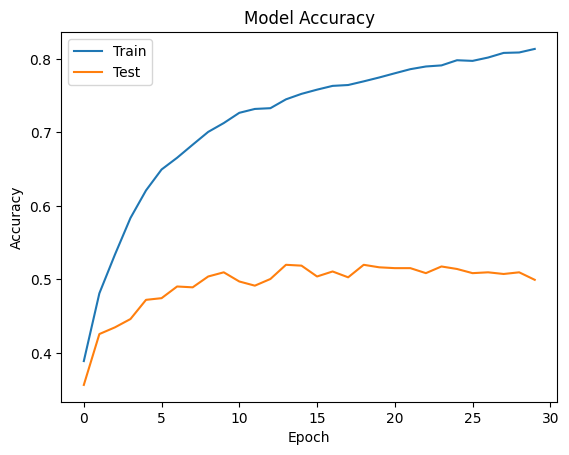

In [80]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

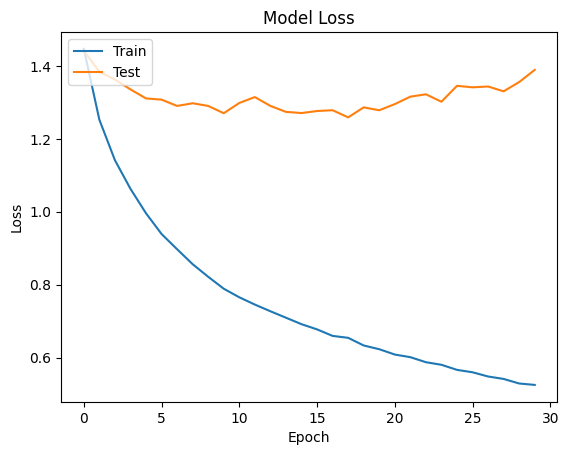

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()